Objective: The model's predictions will be used for strategic decision-making, such as identifying buying or selling opportunities.
Scope: Data Type: Daily closing prices of the stock.
Time Frame: Last 5 years of data.
Evaluation Metric: Choose metrics to evaluate the model (e.g., RMSE, MAE, MAPE).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

2024-12-28 11:09:27.916332: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG']
data = yf.download(tickers, start='2018-01-01', end='2023-01-01')

[*********************100%***********************]  3 of 3 completed


EPA

Based on the business objective, focus on Close as primary target variable for each ticker (AAPL, GOOG, MSFT)

In [3]:
data.head(3)

Price       Adj Close                            Close                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2018-01-02  40.524342  53.059349  79.792908  43.064999  53.250000  85.949997   
2018-01-03  40.517288  53.930225  80.164261  43.057499  54.124001  86.349998   
2018-01-04  40.705490  54.125523  80.869820  43.257500  54.320000  87.110001   

Price            High                              Low                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2018-01-02  43.075001  53.347000  86.309998  42.314999  52.261501  85.500000   
2018-01-03  43.637501  54.314499  86.510002  42.990002  53.160500  85.970001   
2018-01-04  43.367500  54.678501  87.660004  43.020000  54.200100  86.570000   

Price            Open                           Volume                      
Ticker           AAPL       GOOG       MSFT       AAPL      GOOG      MSFT  
Date                                                                        
2018-01-02  42.540001  52.417000  86.129997  102223600  24752000  22483800  
2018-01-03  43.132500  53.215500  86.059998  118071600  28604000  26061400  
2018-01-04  43.134998  54.400002  86.589996   89738400  20092000  21912000

In [4]:
# create dataframe for closing prices for the tickers
closing_prices = data['Close']

# check dataframe 
closing_prices.head()

Ticker,AAPL,GOOG,MSFT
Date,,,
2018-01-02,43.064999,53.250000,85.949997
2018-01-03,43.057499,54.124001,86.349998
2018-01-04,43.257500,54.320000,87.110001
2018-01-05,43.750000,55.111500,88.190002
2018-01-08,43.587502,55.347000,88.279999


In [5]:
# summary statistics for closing prices df
closing_prices.describe()

Ticker,AAPL,GOOG,MSFT
count,1259.000000,1259.000000,1259.000000
mean,98.092897,85.966515,193.873447
std,46.309891,31.244992,74.612296
min,35.547501,48.811001,85.010002
25%,51.022501,58.421999,119.599998
50%,91.632500,73.811501,201.910004
75%,142.864998,113.317753,255.245003
max,182.009995,150.709000,343.109985


- MSFT higher closing average
- Median values close to the mean suggesting relatively symmetric relationship
- MSFT has the highest variability for sd indicating greater volatility. Could impact stability of predictions. High volatility suggests more advanced model like LSTM

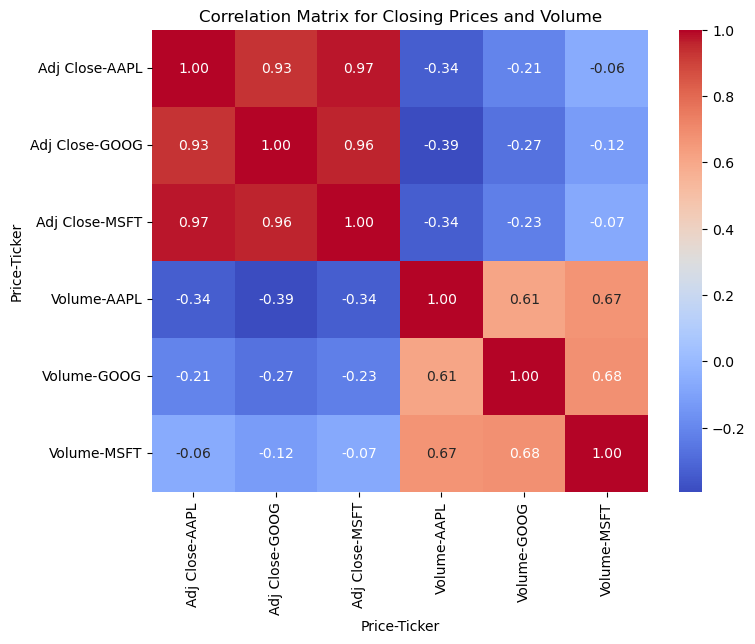

In [6]:
#create correlation matrix
correlation_matrix = data[['Adj Close', 'Volume']].corr()

plt.figure(figsize = (8, 6))
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm', fmt = '.2f')
plt.title('Correlation Matrix for Closing Prices and Volume')
plt.show()

- All stocks prices have a strong positive correlation indicating closing prices move together
- Price vs Volume suggests higher trading volume may coincide with price increases but not strong relationship
- Volume Correlations indicate trading activity reflects broader market activity or investor interest

- Since stock prices are highly correlated focus on one stock for simplicity or can use multivariate time series model

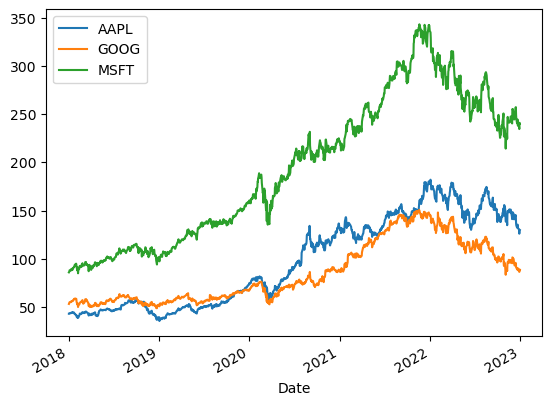

In [7]:
closing_prices.plot(label = "Close Prices")
plt.legend()

In [8]:
# check for stationary data for each ticker for ARIMA model 
for ticker in tickers:
    result = adfuller(closing_prices[ticker])
    print(f"{ticker} ADF Statistic: {result[0]}, p-value: {result[1]}")

AAPL ADF Statistic: -1.073951429942901, p-value: 0.7253472185693876
MSFT ADF Statistic: -1.3093219635176883, p-value: 0.6248967859913954
GOOG ADF Statistic: -1.2108345267877036, p-value: 0.6689176927500176


- All have pvalue higher than 0.05 indicates we fail to reject null hypothesis that data is stationary
- For ARIMA model will need to apply differencing on train and test set

<Axes: ylabel='Density'>

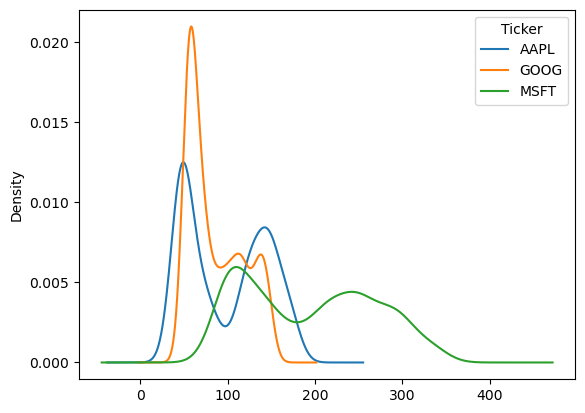

In [9]:
#Distribution of the dataset
closing_prices.plot(kind='kde')

- Wider distribution suggests higher volatility, and more concentrated peak suggests stock stays around the value for longer periods
- AAPL two high peaks with broader dist than GOOG, GOOG less violatile, while MSFT has more continous growth with broader distribution
- Check rolling statistics to verify

## Rolling Features
- Feature discovery 
- Understand moving average vs. overall mean

In [10]:
# Check Rolling features, window average 10 (can change) for short term trends and variability
roll_close = closing_prices.copy()
for ticker in tickers:
    roll_close[f'{ticker}_MA10'] = closing_prices[ticker].rolling(window=10).mean()
    roll_close[f'{ticker}_Volatility'] = closing_prices[ticker].pct_change().rolling(window=10).std()

In [11]:
roll_close.describe()

Ticker,AAPL,GOOG,MSFT,AAPL_MA10,AAPL_Volatility,MSFT_MA10,MSFT_Volatility,GOOG_MA10,GOOG_Volatility
count,1259.000000,1259.000000,1259.000000,1250.000000,1249.000000,1250.000000,1249.000000,1250.000000,1249.000000
mean,98.092897,85.966515,193.873447,98.174166,0.018807,194.094901,0.017222,86.070481,0.017875
std,46.309891,31.244992,74.612296,46.241504,0.010105,74.419764,0.010240,31.229426,0.009116
min,35.547501,48.811001,85.010002,37.663500,0.004489,87.795000,0.004049,50.842051,0.003432
25%,51.022501,58.421999,119.599998,50.979750,0.011835,119.861750,0.010633,58.617338,0.011388
50%,91.632500,73.811501,201.910004,92.340249,0.016600,204.139999,0.015180,73.562724,0.016111
75%,142.864998,113.317753,255.245003,143.270752,0.023206,257.004999,0.021099,113.487876,0.022800
max,182.009995,150.709000,343.109985,178.331999,0.080056,338.364996,0.089051,148.980701,0.066485


- Moving Average smoothes out short term fluctuations and captures trends. Can be included as a feature in predicitive models
- Rolling colatility captures risk and variability, can improve model accuracy 
- Apples higher volatility (1.88%) can be stock to focus on to capture price dyanmics

### Explore AAPL Data

In [12]:
# create AAPL dataframe for feature prep and model testing

aapl_data = closing_prices[['AAPL']].copy()

# Rolling features
aapl_data['AAPL_MA10'] = aapl_data['AAPL'].rolling(window = 10).mean()
aapl_data['AAPL_Volatility'] = aapl_data['AAPL'].pct_change().rolling(window = 10).std()

# Lagged features
aapl_data['AAPL_Adj_Close_lag1'] = aapl_data['AAPL'].shift(1)
aapl_data['AAPL_Adj_Close_lag2'] = aapl_data['AAPL'].shift(2)

# Percent change
aapl_data['AAPL_pct_change'] = aapl_data['AAPL'].pct_change()

# Time-based features
aapl_data['day_of_week'] = aapl_data.index.dayofweek
aapl_data['month'] = aapl_data.index.month

# Drop rows with NaN values (caused by rolling and lagging)
aapl_data = aapl_data.dropna()

aapl_data.describe()

Ticker,AAPL,AAPL_MA10,AAPL_Volatility,AAPL_Adj_Close_lag1,AAPL_Adj_Close_lag2,AAPL_pct_change,day_of_week,month
count,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000,1249.000000
mean,98.529179,98.217860,0.018807,98.460418,98.392094,0.001091,2.021617,6.589271
std,46.236413,46.234206,0.010105,46.253535,46.270511,0.021170,1.400668,3.406289
min,35.547501,37.663500,0.004489,35.547501,35.547501,-0.128647,0.000000,1.000000
25%,51.152500,51.006750,0.011835,51.132500,51.125000,-0.009200,1.000000,4.000000
50%,93.462502,92.575749,0.016600,93.252502,93.172501,0.001001,2.000000,7.000000
75%,142.919998,143.277002,0.023206,142.919998,142.919998,0.012406,3.000000,10.000000
max,182.009995,178.331999,0.080056,182.009995,182.009995,0.119808,4.000000,12.000000


### Scale Data for Model Training

In [13]:
# feature scaling use z-score since features may have different ranges
features_to_scale = ['AAPL', 'AAPL_MA10', 'AAPL_Volatility', 'AAPL_Adj_Close_lag1', 'AAPL_Adj_Close_lag2', 'AAPL_pct_change']

# intialize scaler
scaler = StandardScaler()

# fit and transform data
scaled_features = scaler.fit_transform(aapl_data[features_to_scale])

# create scaled df
scaled_columns = [f"{col}_scaled" for col in features_to_scale]
scaled_data = pd.DataFrame(scaled_features, columns = scaled_columns, index = aapl_data.index)

# concat with original data
aapl_data_scaled = pd.concat([aapl_data, scaled_data], axis = 1)

aapl_data_scaled.head()

,AAPL,AAPL_MA10,AAPL_Volatility,AAPL_Adj_Close_lag1,AAPL_Adj_Close_lag2,AAPL_pct_change,day_of_week,month,AAPL_scaled,AAPL_MA10_scaled,AAPL_Volatility_scaled,AAPL_Adj_Close_lag1_scaled,AAPL_Adj_Close_lag2_scaled,AAPL_pct_change_scaled
Date,,,,,,,,,,,,,,
2018-01-17,44.775002,43.77225,0.007060,44.047501,44.272499,0.016516,2,1,-1.163060,-1.178076,-1.163022,-1.176877,-1.170103,0.728942
2018-01-18,44.814999,43.94800,0.006999,44.775002,44.047501,0.000893,3,1,-1.162194,-1.174273,-1.169065,-1.161142,-1.174968,-0.009321
2018-01-19,44.615002,44.08375,0.007486,44.814999,44.775002,-0.004463,4,1,-1.166522,-1.171336,-1.120869,-1.160277,-1.159239,-0.262418
2018-01-22,44.250000,44.13375,0.007641,44.615002,44.814999,-0.008181,0,1,-1.174419,-1.170254,-1.105519,-1.164603,-1.158374,-0.438132
2018-01-23,44.259998,44.20100,0.007461,44.250000,44.615002,0.000226,1,1,-1.174203,-1.168799,-1.123338,-1.172497,-1.162698,-0.040856


# Model Selection:
- ARIMA, LSTM, Prophet as they cover linear, non-linear, and interpretable forecasting.

### ARIMA model
- Check for stationary data
- Use AutoARIMA for p,q,d values

In [14]:
# check stationarity for aapl_data
result = adfuller(aapl_data['AAPL'])

# Print results
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

# Interpretation
if result[1] > 0.05:
    print("The time series is likely non-stationary (p-value > 0.05).")
else:
    print("The time series is likely stationary (p-value <= 0.05).")

ADF Statistic: -1.1356566345109598
p-value: 0.7006450841609072
Critical Value 1%: -3.4356474307506084
Critical Value 5%: -2.8638793281844253
Critical Value 10%: -2.5680154897465575
The time series is likely non-stationary (p-value > 0.05).


In [15]:
# Split Data into training and test sets
train_size = int(len(aapl_data) * 0.8)
train = aapl_data[:train_size]
test = aapl_data[train_size:]

# verify split
print(f"Train: {len(train)} rows")
print(f"Testing set: {len(test)} rows")

Train: 999 rows
Testing set: 250 rows


In [16]:
train.head()

Ticker,AAPL,AAPL_MA10,AAPL_Volatility,AAPL_Adj_Close_lag1,AAPL_Adj_Close_lag2,AAPL_pct_change,day_of_week,month
Date,,,,,,,,
2018-01-17,44.775002,43.77225,0.007060,44.047501,44.272499,0.016516,2,1
2018-01-18,44.814999,43.94800,0.006999,44.775002,44.047501,0.000893,3,1
2018-01-19,44.615002,44.08375,0.007486,44.814999,44.775002,-0.004463,4,1
2018-01-22,44.250000,44.13375,0.007641,44.615002,44.814999,-0.008181,0,1
2018-01-23,44.259998,44.20100,0.007461,44.250000,44.615002,0.000226,1,1


### Naive Forecasting for Baseline

In [17]:
# Create naive forecast for the test period
last_observed_value = aapl_data['AAPL'].iloc[train_size - 1]
naive_forecasts = pd.Series(last_observed_value, index=test.index)

# Evaluate using RMSE
rmse_naive = mean_squared_error(test['AAPL'], naive_forecasts, squared=False)
print(f"Naive Forecast RMSE: {rmse_naive}")

Naive Forecast RMSE: 30.197553581847334


- Make Data Stionary for ARIMA

In [18]:
# make data stationary for arima model
aapl_diff = aapl_data['AAPL'].diff().dropna().copy()

# Re-check stationarity
result_diff = adfuller(aapl_diff)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

ADF Statistic (Differenced): -10.414688960192686
p-value (Differenced): 1.766919677920362e-18


In [19]:
# Split Data into training and test sets for ARIMA
train_size = int(len(aapl_diff) * 0.8)
train_diff = aapl_diff[:train_size]
test_diff = aapl_diff[train_size:]

# verify split
print(f"Train: {len(train_diff)} rows")
print(f"Testing set: {len(test_diff)} rows")

Train: 998 rows
Testing set: 250 rows


ARIMA model

In [20]:
stepwise_fit = auto_arima(train_diff.dropna(),
                             start_p = 1, start_q = 1,
                             max_p = 5, max_q = 5,
                             seasonal = False,
                             trace = True)
print(f"Optimal ARIMA order: {stepwise_fit.order}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4030.454, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4035.812, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4029.116, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4029.504, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4030.654, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4032.454, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=4024.266, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4032.135, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=4026.044, Time=0.08 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=4025.860, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=4024.580, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=4027.831, Time=0.34 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.178 seconds
Optimal ARIMA order: (1, 0, 0)


In [21]:
# Train ARIMA Model
model = ARIMA(train_diff, order=(1, 0, 0))
arima_model = model.fit()

# Forecast for the length of the test set
forecast_diff = arima_model.forecast(steps=len(test_diff))

# Get the last training value for reverse differencing
last_train_value = aapl_data['AAPL'].iloc[train_size - 1]

# Reverse Differencing to Return to Original Scale
forecast_arima_original_scale = forecast_diff.cumsum() + last_train_value

# Align forecast index with test data
forecast_arima_original_scale = pd.Series(forecast_arima_original_scale.values, index=test.index)

# Drop NaNs (if any)
forecast_arima_original_scale = forecast_arima_original_scale.dropna()

# Adjust actual test data for length and ensure it's only the 'AAPL' column
actual_test = aapl_data['AAPL'].iloc[train_size:train_size + len(forecast_arima_original_scale)]

# Drop NaNs (if any)
actual_test = actual_test.dropna()
forecast_arima_original_scale = forecast_arima_original_scale.dropna()

# Verify lengths
print(f"\nLength of actual test data: {len(actual_test)}")
print(f"Length of forecast: {len(forecast_arima_original_scale)}")

# Evaluate RMSE
if len(actual_test) == len(forecast_arima_original_scale):
    rmse_arima = mean_squared_error(actual_test, forecast_arima_original_scale, squared=False)
    print(f"\nARIMA RMSE (Original Scale): {rmse_arima}")
else:
    print("\nError: Lengths of actual_test and forecast_arima_original_scale do not match.")


Length of actual test data: 250
Length of forecast: 250

ARIMA RMSE (Original Scale): 44.604112288210274


### LSTM Model Training

In [22]:
# reshape train and test
train_reshaped = train['AAPL'].values.reshape(-1, 1)
test_reshaped = test['AAPL'].values.reshape(-1, 1)

#scale data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_reshaped)
test_scaled = scaler.transform(test_reshaped)

# create sequences
def create_sequences(data, seq_length = 10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation = 'relu', return_sequences = True, input_shape = (seq_length, 1)),
    LSTM(50, activation = 'relu'),
    Dense(1)
])
lstm_model.compile(optimizer = 'adam', loss = 'mse')

# train the model
lstm_model.fit(X_train, y_train, epochs = 20, batch_size = 16)

# forecast
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

# Adjust y_test for evaluation to match the length of lstm_predictions
y_test_adjusted = test_scaled[seq_length:seq_length + len(lstm_predictions)]

# Rescale y_test_adjusted back to the original scale
y_test_inverse = scaler.inverse_transform(y_test_adjusted)

# Evaluate using RMSE
rmse_lstm = mean_squared_error(y_test_inverse, lstm_predictions_inverse, squared=False)
print(f"LSTM RMSE: {rmse_lstm}")



Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0864
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.1701e-04
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.4410e-04
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.9041e-04
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5634e-04
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3912e-04
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.2656e-04
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.0848e-04
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.7680e-04
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3709e-04
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2305e-04
Epoch 12/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0283e-04
Epoch 13/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.1051e-04
Epoch 14/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.1428e-04
Epoch 15/20
62/62 ━━━━

### Prophet Model

In [23]:
# Prepare training data for Prophet
prophet_train = train['AAPL'].reset_index()
prophet_train.columns = ['ds', 'y']

# Train Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_train)

# Create future dataframe for forecasting
future = test['AAPL'].reset_index()
future.columns = ['ds', 'y']

# Predict
forecast = prophet_model.predict(future[['ds']])

# Evaluate
rmse_prophet = mean_squared_error(test['AAPL'], forecast['yhat'], squared=False)
print(f"Prophet RMSE: {rmse_prophet}")

11:09:53 - cmdstanpy - INFO - Chain [1] start processing
11:09:54 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 45.0138767920423


### Random Forest & XGBoost 
- Use rolling features
- Shuts down kernal, computational power error? 

In [24]:
# from xgboost import XGBRegressor
# from sklearn.model_selection import train_test_split

# # Prepare features and target
# features = ['AAPL_MA10', 'AAPL_Volatility', 'AAPL_Adj_Close_lag1', 'AAPL_Adj_Close_lag2', 'day_of_week', 'month']
# X_train = train[features]
# y_train = train['AAPL']
# X_test = test[features]
# y_test = test['AAPL']

# # Train XGBoost
# xgb_model = XGBRegressor(n_estimators = 100, learning_rate = 0.1, max_depth = 5, random_state = 42)
# xgb_model.fit(X_train, y_train)

# # Predict and evalue
# xgb_predictions = xgb_model.predict(X_test)
# rmse_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
# print(f"XGBoost RMSE: {rmse_xgb}")

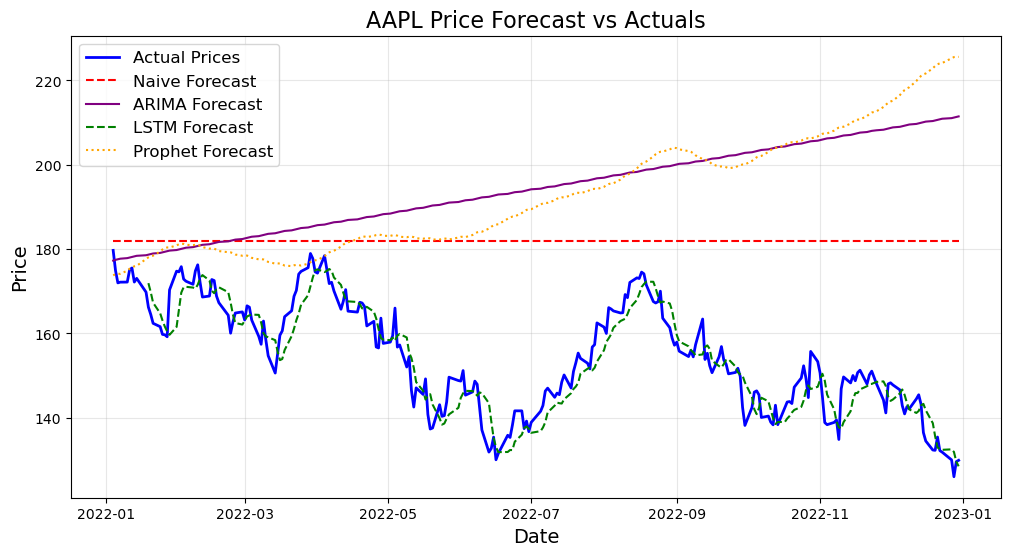

In [25]:
# Plot actual vs forecasted prices for AAPL
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['AAPL'], label='Actual Prices', color='blue', linewidth=2)
plt.plot(naive_forecasts.index, naive_forecasts, label='Naive Forecast', color='red', linestyle='--')
plt.plot(forecast_arima_original_scale.index, forecast_arima_original_scale, label='ARIMA Forecast', color='purple')
plt.plot(test.index[seq_length:], lstm_predictions_inverse.flatten(), label='LSTM Forecast', color='green', linestyle='--')
plt.plot(test.index, forecast['yhat'], label='Prophet Forecast', color='orange', linestyle=':')
plt.title('AAPL Price Forecast vs Actuals', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

### Findings
- Leveage LSTM for trading algorithms given it's performance
- Continous training and fine tuning on LSTM model with fresh data
### Improvements
- Hypertuning optimization like layers and learning rate can lead to better performance
- Ensemble models could leverage the strenghts of each model and reduce errors
- Test across other stocks and analyze how well model generalizes 